<a id='section_id'></a>

<h1> <div align="center"><a> Определение стоимости автомобилей. </a></div> 

## Подготовка данных
### Первичный анализ исходных данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

In [2]:
df_0 = pd.read_csv("/datasets/autos.csv")
display(df_0.head(3))
df_0.info()
display(f'Количество дубликатов: {df_0.duplicated().sum()}')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

'Количество дубликатов: 4'

In [3]:
# оценим пропуски в столбцах
df_0.isna().mean().sort_values(ascending = False).head(6)

NotRepaired    0.200791
VehicleType    0.105794
FuelType       0.092827
Gearbox        0.055967
Model          0.055606
DateCrawled    0.000000
dtype: float64

In [4]:
# оценим статистику по количественным признакам
df_0.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [5]:
# оценим статистику по категориальным признакам
df_0.describe(include=['object', 'bool'])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


#### Основные выводы анализа исходных данных:
- выборка очень большая: таблица имеет 354 369 строк и 16 столбцов; 
- требуется переименование столбцов с использованием нотации snake case;
- в массиве представлены категориальные (VehicleType, Gearbox, Model, FuelType, Brand), булев (NotRepaired) и количественные признаки с типами данных int. Также есть 3 столбца строкового типа, которые содержат даты (DateCrawled, DateCreated, LastSeen); их требуется перевести в тип datetime64;
- имеются пропущенные значения в 5 столбцах NotRepaired (20% пропусков), VehicleType (11% пропусков), FuelType (9% пропусков), Gearbox (6% пропусков) и Model (6% пропусков);
- обнаружено 4 явных дубликата;
- выявлены cтатистические выбросы в столбцах Price, RegistrationYear, RegistrationMonth	и Power;
- в столбце NumberOfPictures одни нули, поэтому его можно смело удалить;
- более половины автомобилей имеют автопробег 150 000 км;
- среди категориальных признаков наибольшее количество уникальных значений имеет признак Model (250).

### Первичная обработка выборки
Сначала переименуем столбцы, поменяем тип данных для столбцов с датами и удалим явные дубликаты.

In [6]:
df_0.columns = df_0.columns.str.lower()
df_0.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [7]:
df_0.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
df_0['date_crawled'] = pd.to_datetime(df_0['date_crawled'])
df_0['date_created'] = pd.to_datetime(df_0['date_created'])
df_0['last_seen'] = pd.to_datetime(df_0['last_seen'])
df_0 = df_0.drop_duplicates().reset_index(drop=True)

In [8]:
# оценим временной период наших данных
df_0['date_created_year'] = pd.DatetimeIndex(df_0['date_created']).year
df_0['date_created_mo'] = pd.DatetimeIndex(df_0['date_created']).month
df_0.pivot_table(index=['date_created_year'], columns ='date_created_mo', values='price', aggfunc='count')

date_created_mo,1,2,3,4,6,8,9,11,12
date_created_year,,,,,,,,,
2014,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2015,NaN,NaN,1.0,NaN,1.0,2.0,3.0,9.0,9.0
2016,70.0,397.0,296754.0,57118.0,NaN,NaN,NaN,NaN,NaN


**Большая часть анкет была создана в январе - апреле 2016 году. Единичные анкеты за 2014 и 2015 годы лучше удалить для однородности периода данных.**

In [9]:
df = df_0.query('date_created_year == 2016')
display(f'Количество дубликатов: {df_0.duplicated().sum()}')

'Количество дубликатов: 0'

**Теперь удалим столбцы, которые не несут полезной нагрузки:**
 - столбцы с датами date_crawled, date_created,  last_seen, date_created_year, date_created_mo и registration_month  
 - количественные признаки number_of_pictures и postal_code 
 - категориальный признак model, который насчитывает 250 уникальных значений и к тому же имеет пересекающиеся значения по признаку brand (например, модель grand есть и у jeep, и у suzuki, и у chrysler)

In [10]:
# power.groupby('model')['brand'].unique() - можно увидеть, что есть бренды, в которых пересекаются названия моделей.
df = df.drop(['date_crawled', 'registration_month', 'date_created',
              'number_of_pictures', 'postal_code', 'last_seen', 'date_created_year', 'date_created_mo', 'model'], axis=1)
display(df.shape)
df.head(3)

(354339, 9)

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,125000,gasoline,jeep,NaN


### Изучение признаков

#### Количественные признаки
Помимо целевого у нас осталось 8 признаков: 3 количественных, 4 категориальных и 1 булев. Изучим каждый из признаков более внимательно. Начнем с количественных признаков, в первую очередь с целевого.

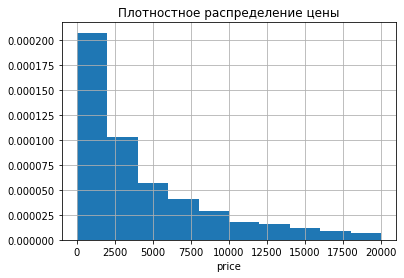

10772

In [11]:
x = df["price"].hist(bins=10, range=(0, 20000), density=True)
plt.xlabel('price')
plt.title("Плотностное распределение цены")
plt.show()
len(df[df['price'] == 0])

Мы видим, что большая часть цен находится в диапазоне до 2000 евро. Однако стоит отметить почти 11 тысяч строк (порядка 3% от общей выборки), по которым значения в столбце price равно 0. В качестве диапазона анализируемых значений можно оставить 95% доверительный интервал, отбросив минимальные и максимальные значения. 

In [12]:
print(sorted(df['registration_year'].unique(),reverse=False))

[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500, 8888, 9000, 9229, 9450, 9996, 9999]


В столбце год регистрации автомобиля мы видим явно выбивающиеся значения.

(1980.0, 2020.0)

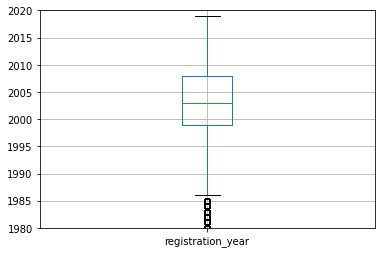

In [13]:
# построим диаграмму размаха для более глубокого анализа
df.boxplot(column='registration_year')
plt.ylim(1980, 2020)
# учитывая, что анкеты были созданы в начале 2016 год, оставим период регистрации автомобиля между 1985 и 2015 годами. 

,2000,1999,2005,2001,2006,2003,2004,2002,1998,2007
registration_year,0.075409,0.06998,0.068065,0.061962,0.061266,0.060851,0.06038,0.058782,0.055114,0.05291


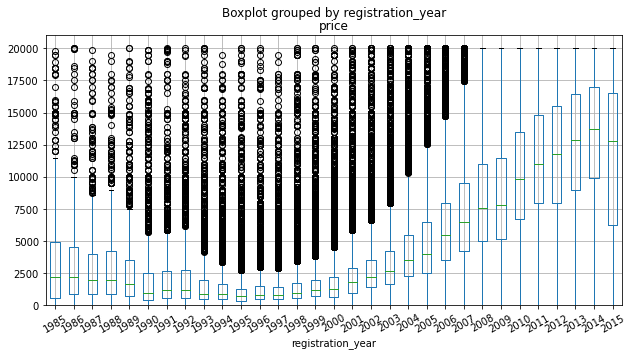

In [14]:
m = df.query('registration_year >= 1985 and registration_year <= 2015')
display(pd.DataFrame(m["registration_year"].value_counts(normalize=True)).head(10).T)
m.boxplot(column = 'price', by = "registration_year", rot=30, figsize=(10, 5))
plt.ylim(0, 21000)
plt.show()

Наблюдаем общую зависимость: чем позже был год регистрации автомобиля, тем дороже он стоит.

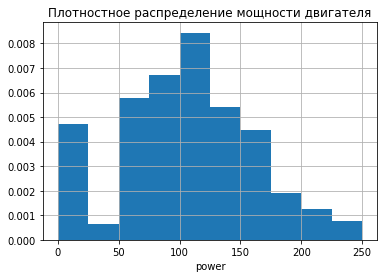

40223

In [15]:
#построим плотностную гистограмму для признака power
x = df["power"].hist(bins=10, range=(0, 250), density=True)
plt.xlabel('power')
plt.title("Плотностное распределение мощности двигателя")
plt.show()
len(df[df['power'] == 0])

Мы видим значительное количество строк (более 10% от общей выборки), по которым значения в столбце power равно 0. Стратегию работы с пропусками и выбросами мы определим позже, но сначала нужно определить диапазон допустимых значений. Можно использовать общедоступную информацию, что двигатели малолитражных машин начинаются от 50 л.с., а мощные модели могут достигать 500 л.с.

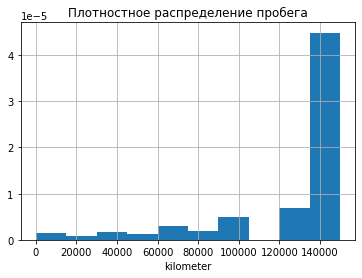

In [16]:
#построим плотностную гистограмму и ящик с усами для пробега
x = df["kilometer"].hist(bins=10, range=(0, 150000), density=True)
plt.xlabel('kilometer')
plt.title("Плотностное распределение пробега")
plt.show()

,150000,125000,100000,90000,80000,70000,60000,5000,50000,40000
kilometer,0.672223,0.10287,0.041994,0.032638,0.028351,0.024248,0.021008,0.018053,0.017585,0.013857


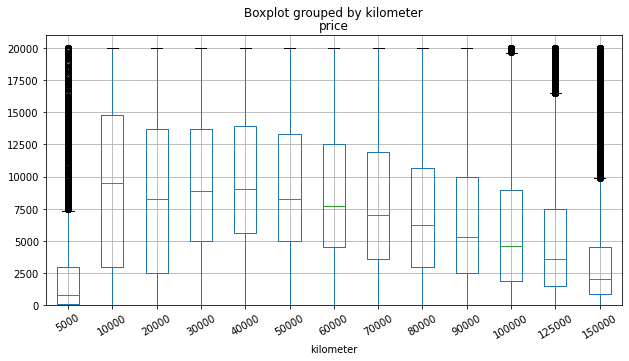

In [17]:
display(pd.DataFrame(df["kilometer"].value_counts(normalize=True)).head(10).T)
df.boxplot(column = 'price', by = "kilometer", rot=30, figsize=(10, 5))
plt.ylim(0, 21000)
plt.show()

In [18]:
display(df.pivot_table(index=['kilometer'], values='price', aggfunc='count').T)
df.query("price == 0").pivot_table(index=['kilometer'], values='price', aggfunc='count').T

kilometer,5000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,125000,150000
price,6397,1221,3974,4433,4910,6231,7444,8592,10046,11565,14880,36451,238195


kilometer,5000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,125000,150000
price,1025,76,138,104,55,79,75,100,147,173,436,692,7672


67% автомобилей имеют пробег 150 000 км; Диаграмма размаха показывает, что чем меньше пробег у машины, тем дороже она стоит. 
Однако сильно выбиваются машины, которые имеют минимальный пробег 5 000 км - это связано с тем, что именно в этой группе доля цен со значением 0 самая высокая (16%). Так же обратим внимание, что для любого автопробега разброс цены автомобиля одинаковый от 0 до 20 000 евро. Это говорит нам о выбросах в целевом признаке.

#### Категориальные признаки
Продолжим исследовать уже категориальные признаки.

,sedan,small,wagon,bus,convertible,coupe,suv,other
vehicle_type,0.288606,0.251935,0.205658,0.090809,0.063749,0.051005,0.03786,0.010377


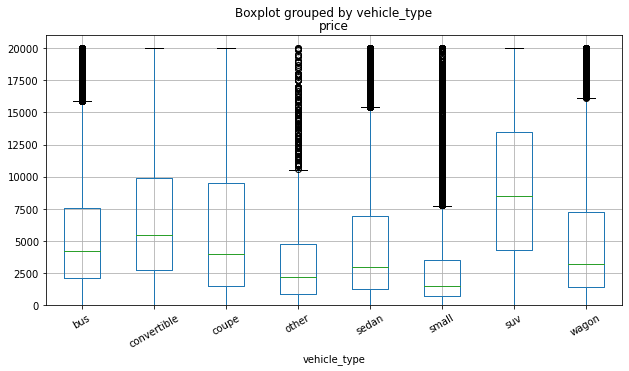

In [19]:
display(pd.DataFrame(df["vehicle_type"].value_counts(normalize=True)).T)
df.boxplot(column = 'price', by = "vehicle_type", rot=30, figsize=(10, 5))
plt.ylim(0, 21000)
plt.show()

Топ-3 типов автомобильного кузова это sedan, small и wagon. Диаграмма размаха демонстрирует зависимость стоимости автомобиля от типа кузова. Дороже всего оценивается тип suv (sport utility vehicle).

,manual,auto
gearbox,0.801879,0.198121


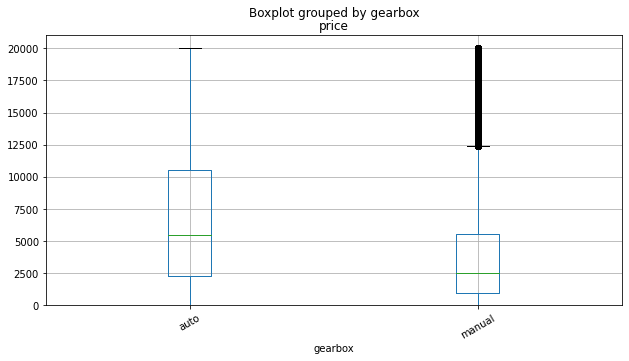

In [20]:
display(pd.DataFrame(df["gearbox"].value_counts(normalize=True)).T)
df.boxplot(column = 'price', by = "gearbox", rot=30, figsize=(10, 5))
plt.ylim(0, 21000)
plt.show()

80% выборки это машины с ручной коробкой передач. Диаграмма размаха показвает, что машины с автоматической коробкой оцениваются дороже чем автомобили с ручной коробкой передач.

,petrol,gasoline,lpg,cng,hybrid
fuel_type,0.672988,0.307099,0.016516,0.001758,0.000725


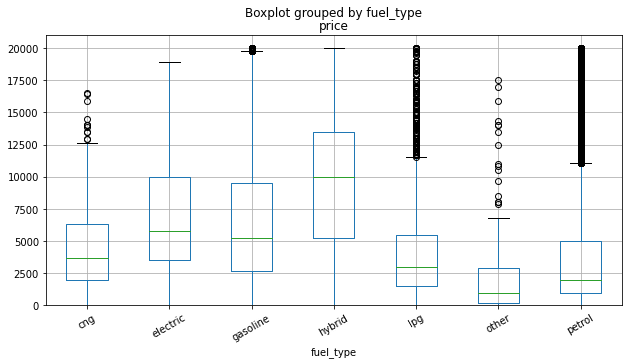

In [21]:
display(pd.DataFrame(df["fuel_type"].value_counts(normalize=True)).head().T)
df.boxplot(column = 'price', by = "fuel_type", rot=30, figsize=(10, 5))
plt.ylim(0, 21000)
plt.show()

97% машин работают на бензине (petrol(UK) и gasoline (USA)); Диаграмма размаха демонстрирует зависимость стоимости автомобиля от типа топлива: дороже всех стоят автомобили, которые могут использовать гибиридный вид топлива.

,volkswagen,opel,bmw,mercedes_benz,audi
brand,0.217331,0.112686,0.104174,0.090425,0.083121


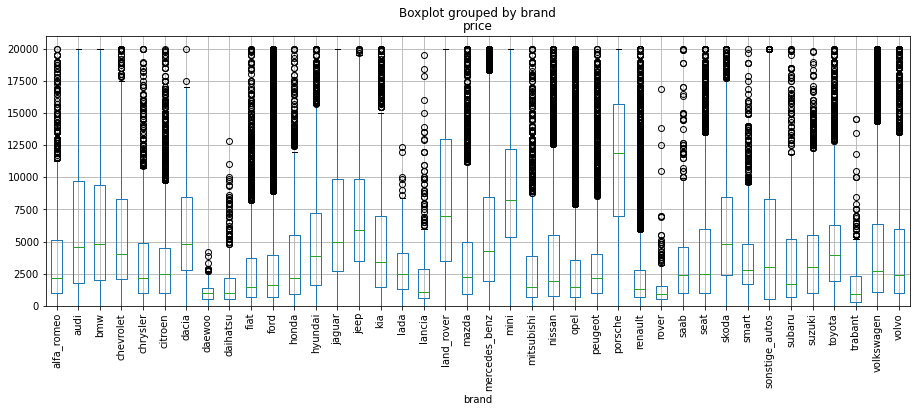

In [22]:
display(pd.DataFrame(df["brand"].value_counts(normalize=True)).head().T)
df.boxplot(column = 'price', by = "brand", rot=90, figsize=(15, 5))
plt.ylim(0, 21000)
plt.show()

Топ-3 марок автомобилей по количеству это volkswagen, opel и bmw. Диаграмма размаха демонстрирует зависимость стоимости автомобиля от марки автомобиля. Наиболее высоко оцениваются автомобили марки porsche.

,no,yes
not_repaired,0.872696,0.127304


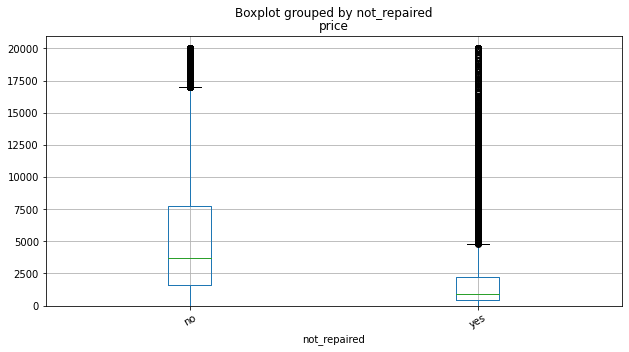

In [23]:
display(pd.DataFrame(df["not_repaired"].value_counts(normalize=True)).T)
df.boxplot(column = 'price', by = "not_repaired", rot=30, figsize=(10, 5))
plt.ylim(0, 21000)
plt.show()

87% автомобилей не были в ремонте - это довольно странно, принимая во  внимание, что 67% это автомобили с пробегом 150 000 км.
Диаграмма размаха показывает, что машины, которые не попадали в ремонт, стоят дороже.
Согласно открытым источникам пробег в 100 000 км является границей заводской гарантии. Для заполнения пропусков в этом столбце, используем правило: при пробеге от 100 000 км. и выше признак принимает значение "yes".

### Подготовка выборок

Итак, мы убедились, что **все оставленные признаки значимы и в той или иной степени влияют на стоимость автомобиля**.

Для решения поставленной задачи попробуем две стратегии:
 - 1) Удалим пропуски и выбросы во всех оставленных столбцах - размер исходной выборк позволяет это сделать;
 - 2) Где это возможно заменим пропуски/выбросы согласно нашим допущениям, для оставшихся случаев их удалим.

Таким образом, мы получим две выборки, для которых обучим разные модели и которые сравним между собой по RMSE.

Всего мы обнаружили пропуски в 5 столбцах NotRepaired (20% пропусков), VehicleType (11% пропусков), FuelType (9% пропусков), Gearbox (6% пропусков) и Model (6% пропусков). При этом признак Model был исключен, а в оставшихся столбцах заполнить пропуски можно, используя следующие допущения:
 * not_repaired - при пробеге свыше 100 000 км. машина точно ремонтировалась
 * vehicle_type - наиболее частый тип для того или иного бренда
 * fuel_type - наиболее частый тип для того или иного бренда
 * gearbox - наиболее частый тип для того или иного бренда
 
Что касается выбросов, то они были выявлены в 3 столбцах Price, RegistrationYear и Power. Для каждого мы определили диапазон допустимых значений:
 * registration year - период  с 1985 по 2015 годы;
 * power - диапазон от 50 до 500 лс;
 * price - 95% доверительный интервал после обработки выборки
 
Выбросы по этим столбцам могут быть обработаны с учетом следующих допущений:
 * registration year - обработке не подлежат;
 * power - среднее значение для того или иного бренда;
 * price - обработке не подлежат

#### Стратегия удаления пропусков и выбросов
**Подготовим первую выборку.**

In [24]:
df_1 = df.dropna().reset_index(drop=True) # сначала удалим пропуски во всех столбцах
print(df.shape, df_1.shape)
df_1 = df_1.query('registration_year >= 1985 and registration_year <= 2015 \
                   and power >= 50 and power <= 500') # оставим только допустимые диапазоны
print(df.shape, df_1.shape)

(354339, 9) (252290, 9)
(354339, 9) (235678, 9)


In [25]:
len(df_1[df_1['price'] == 0])

3001

In [26]:
#найдем 95%-й доверительный интервал для целевого признака
price = pd.Series(df_1["price"])
lower = price.quantile(0.025)
upper = price.quantile(0.975)
print("Нижняя граница 95% доверительного интервала:", "{:,.2f}".format(lower).replace(',', ' '))
print("Верхняя граница 95% доверительного интервала:", "{:,.2f}".format(upper).replace(',', ' '))

Нижняя граница 95% доверительного интервала: 250.00
Верхняя граница 95% доверительного интервала: 17 500.00


In [27]:
#оставим выборку в пределах 95% доверительного интервала для целевого признака
df_1 = df_1.query('price >= 250 and price <= 17500')
print(df.shape, df_1.shape)

(354339, 9) (224695, 9)


**После всех преобразований первая выборка имеет 225 000 строк, или 63% от исходной выборки.**

#### Стратегия заполнения пропусков и выбросов
Теперь подготовим вторую выборку. Для начала заполним пропуски в столбцах vehicle_type, fuel_type и gearbox модой для того или иного бренда.

In [28]:
df_2 = df
df_2['vehicle_type'] = df['vehicle_type'].fillna(df.groupby('brand')['vehicle_type'].transform( lambda x:x.value_counts().idxmax() if x.count()!=0 else 'unknown'))
df_2['fuel_type'] = df['fuel_type'].fillna(df.groupby('brand')['fuel_type'].transform( lambda x:x.value_counts().idxmax() if x.count()!=0 else 'unknown'))
df_2['gearbox'] = df['gearbox'].fillna(df.groupby('brand')['gearbox'].transform( lambda x:x.value_counts().idxmax() if x.count()!=0 else 'unknown'))

In [29]:
# осталось заполнить пропуски в столбце not_repaired
def not_repaired_upd(row):
    if row["kilometer"] >= 100000:
        return "yes"
    return "no"
       
df_2.loc[df_2.not_repaired.isna(), "not_repaired"] = df_2[df_2.not_repaired.isna()].apply(not_repaired_upd, axis=1)

In [30]:
df_2.head()

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,0,150000,petrol,volkswagen,yes
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,125000,gasoline,jeep,yes
3,1500,small,2001,manual,75,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,90000,gasoline,skoda,no


In [31]:
# теперь заполним выбросы в столбце power средними значениями по брендам
power = df.query('power >= 50 and power <= 500').pivot_table(index=['brand'], values='power', aggfunc='mean')
a = df_2.query('power < 50 or power > 500').merge(power, on='brand', how='left')
a = a.rename(columns={'power_y': 'power'})
a.drop('power_x', axis = 1, inplace=True)

# сделаем срез с актуальными данными
b = df_2.query('power >= 50 and power <= 500')

#теперь объединим срез с актуальными данными и срез с обновленными значениями в части признака vehicle_type
df_2 = pd.concat([a, b])

In [32]:
#убедимся,что количество строк в выборке не изменилось, а выбросов не осталось
print(df.shape, df_2.shape)
df_2.info()

(354339, 9) (354339, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 354339 entries, 0 to 354364
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              354339 non-null  int64  
 1   vehicle_type       354339 non-null  object 
 2   registration_year  354339 non-null  int64  
 3   gearbox            354339 non-null  object 
 4   kilometer          354339 non-null  int64  
 5   fuel_type          354339 non-null  object 
 6   brand              354339 non-null  object 
 7   not_repaired       354339 non-null  object 
 8   power              354339 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 27.0+ MB


In [33]:
df_2 = df_2.reindex(columns = ['price', 'registration_year', 'power', 'kilometer', 'brand', 'vehicle_type',
       'fuel_type', 'gearbox', 'not_repaired'])
df_2.head()

,price,registration_year,power,kilometer,brand,vehicle_type,fuel_type,gearbox,not_repaired
0,480,1993,104.546488,150000,volkswagen,sedan,petrol,manual,yes
1,450,1910,104.310558,5000,ford,small,petrol,manual,no
2,245,1994,104.546488,150000,volkswagen,sedan,petrol,manual,no
3,1500,2016,91.038865,150000,renault,small,gasoline,manual,no
4,0,1990,102.305206,150000,opel,small,petrol,manual,yes


In [34]:
#оставим выборку в пределах 95% доверительного интервала для целевого признака, найденного для первой выборки
df_2 = df_2.query('price >= 250 and price <= 17500')
print(df.shape, df_2.shape)

(354339, 9) (327862, 9)


**Мы получили вторую выборку df_2, в которой заменили пропуски и выбросы согласно определенному алгоритму. Ее размер составил 93% от нашей исходной выборки.**

#### Матрицы корреляций количественных и категориальных признаков
Построим корреляционные матрицы для исходной выборки и полученных двух после обработки.

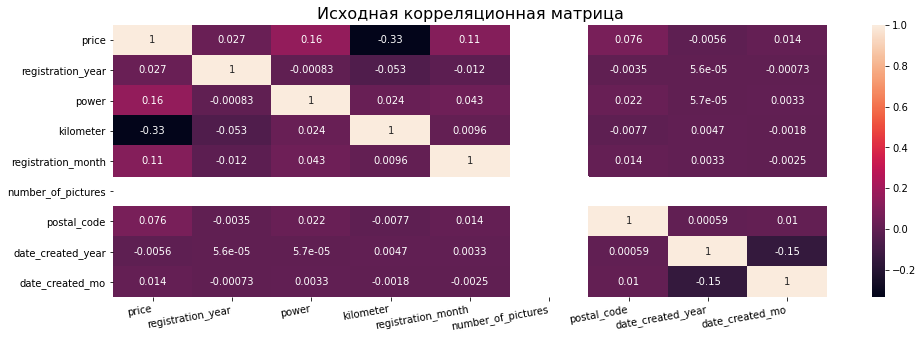

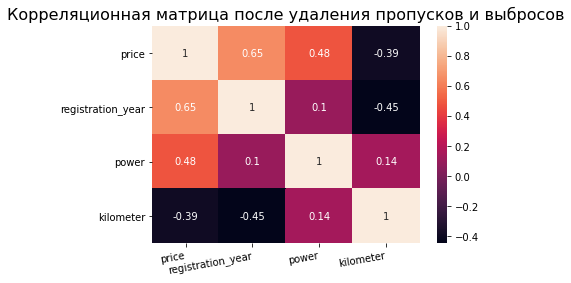

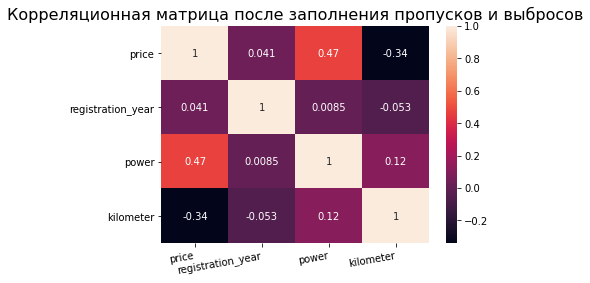

In [35]:
plt.figure(figsize=(16,5))
a = sns.heatmap(df_0.corr(),annot=True)
a.set_xticklabels(a.get_xticklabels(), rotation=10, horizontalalignment='right')
a.set_yticklabels(a.get_yticklabels(), rotation=0, horizontalalignment='right')
a.axes.set_title("Исходная корреляционная матрица", fontsize=16)
plt.show()

c = sns.heatmap(df_1.corr(),annot=True)
c.set_xticklabels(c.get_xticklabels(), rotation=10, horizontalalignment='right')
c.set_yticklabels(c.get_yticklabels(), rotation=0, horizontalalignment='right')
c.axes.set_title("Корреляционная матрица после удаления пропусков и выбросов", fontsize=16)
plt.show()

d = sns.heatmap(df_2.corr(),annot=True)
d.set_xticklabels(d.get_xticklabels(), rotation=10, horizontalalignment='right')
d.set_yticklabels(d.get_yticklabels(), rotation=0, horizontalalignment='right')
d.axes.set_title("Корреляционная матрица после заполнения пропусков и выбросов", fontsize=16)
plt.show()

В исходной выборке можно было говорить об умеренной корреляции между ценой и пробегом автомобиля. После обработки значения коэффициентов корреляции заметно выросли, особенно для признаков registration year и power.
Стоит обратить внимание, что показатели матрицы после удаления пропусков и выбросов в целом выше, нежели у матрицы после заполнения пропусков и выбросов. 

Text(0.5, 1.0, 'Коэффициенты Крамера для выборки после заполнения пропусков и выбросов')

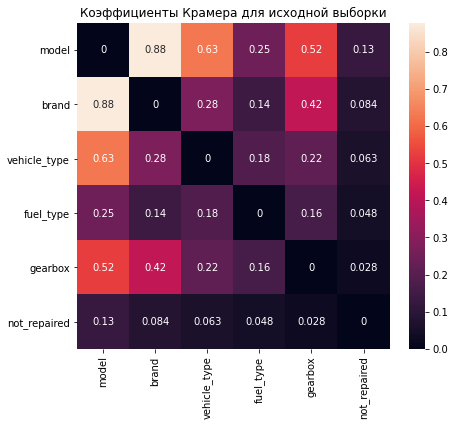

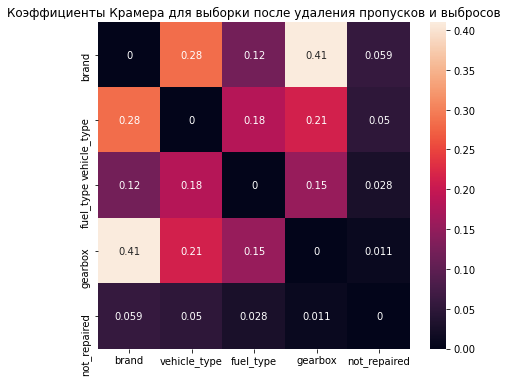

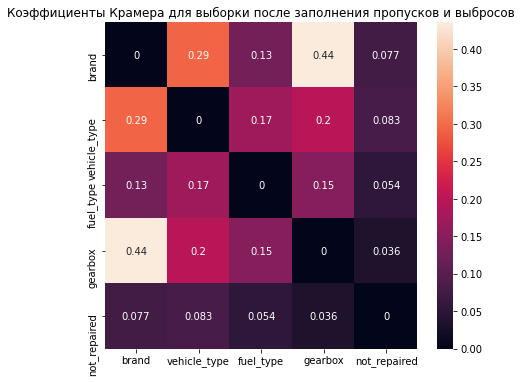

In [36]:
# построим матрицу коэффициентов Крамера для категориальных признаков 
def cramers_corrected_stat(confusion_matrix):
    chi2 = st.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


cols = ['model', 'brand', 'vehicle_type',  'fuel_type', 'gearbox', 'not_repaired']
corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df_0[col1], df_0[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]


corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Коэффициенты Крамера для исходной выборки")

cols = ['brand', 'vehicle_type',  'fuel_type', 'gearbox', 'not_repaired']
corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df_1[col1], df_1[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Коэффициенты Крамера для выборки после удаления пропусков и выбросов")

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df_2[col1], df_2[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Коэффициенты Крамера для выборки после заполнения пропусков и выбросов")

В первую очередь обратим внимание на высокое значение коэфициента для исходной выборки в паре bran - model: 0.88.
Это говорит о сильной связи между этими двумя признаками и подвтерждает правильность нашего решения об исключении признака model для последующего анализа. Значения других  коэффициентов практически не изменились. Можно отметить умеренно сильную связь между признаками brand-gearbox и brand-vehicle_type.

#### Кодирование категориальных признаков методом OHE
Для последующего обучения моделей линейной регрессии, решающего дерева и случайного леса преобразуем категориальные признаки в количественные с помощью метода OHE и сохраним как отдельные выброки. Между собой сильно связаны значения в столбцах gearbox и  not_repaired, поэтому для них можно выбросить первый столбец.

In [37]:
df_1["gearbox"] = pd.get_dummies(df_1["gearbox"], drop_first=True)
df_1["not_repaired"] = pd.get_dummies(df_1["not_repaired"], drop_first=True)
df_1_ohe = pd.get_dummies(df_1)

df_1_ohe.head(3)

,price,registration_year,gearbox,power,kilometer,not_repaired,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
1,1500,2001,1,75,150000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3600,2008,1,69,90000,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,650,1995,1,102,150000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# аналогично подготовим нашу вторую выборку
df_2["gearbox"] = pd.get_dummies(df_2["gearbox"], drop_first=True)
df_2["not_repaired"] = pd.get_dummies(df_2["not_repaired"], drop_first=True)
df_2_ohe = pd.get_dummies(df_2)

df_2_ohe.head(3)

,price,registration_year,power,kilometer,gearbox,not_repaired,brand_alfa_romeo,brand_audi,brand_bmw,brand_chevrolet,...,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,fuel_type_cng,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol
0,480,1993,104.546488,150000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,450,1910,104.310558,5000,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1500,2016,91.038865,150000,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


Итак, мы подготовили две выборки, преобразовали категориальные признаки в численные с помощью техники OHE. Все готово для последующего обучения моделей.
**Таким образом, мы получили 2 пары выборок c кодированием категориальных признаков (выборки df_1_ohe df_2_ohe) и без (выборки df_1 и df_2).**

[В начало](#section_id)

## Обучение моделей
### Разделение выборок

Разобьем данные на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные пошагово разобьем в соотношении 3:1:1. Далее объявим переменные с признаками и целевым признаком для каждой из полученных выборок.

In [39]:
%%time
samples = [df_1, df_2, df_1_ohe, df_2_ohe] # подаем список из 2 выборок до OHE и 2 после OHE
x_train = []
y_train = []
x_valid = []
y_valid = []
x_test = []
y_test = []

for index in range(4):
    df_train, df_middle = train_test_split(samples[index], test_size=0.4, random_state=12345)
    df_valid, df_test = train_test_split(df_middle, test_size=0.5, random_state=12345)
    x_train.append(df_train.drop(['price'], axis = 1))
    y_train.append(df_train['price'])
    x_valid.append(df_valid.drop(['price'], axis = 1))
    y_valid.append(df_valid['price'])
    x_test.append(df_test.drop(['price'], axis = 1))
    y_test.append(df_test['price']) 

CPU times: user 352 ms, sys: 59.4 ms, total: 412 ms
Wall time: 418 ms


### Масштабирование количественных признаков

In [40]:
# cтандартизируем количественные признаки для обучающих выборок,
# а для валидационных и тестовых выборок уже согласно ранее запомненным параметрам

scaler = StandardScaler()
numeric =  ['registration_year', 'power', 'kilometer']
x_train[2][numeric] = scaler.fit_transform(x_train[2][numeric])
x_valid[2][numeric] = scaler.transform(x_valid[2][numeric])
x_test[2][numeric] = scaler.transform(x_test[2][numeric])


scaler = StandardScaler()
numeric =  ['registration_year', 'power', 'kilometer']
x_train[3][numeric] = scaler.fit_transform(x_train[3][numeric])
x_valid[3][numeric] = scaler.transform(x_valid[3][numeric])
x_test[3][numeric] = scaler.transform(x_test[3][numeric])

### Линейная регрессия

In [41]:
%%time
x_train_ohe = [x_train[2], x_train[3]]
y_train_ohe = [y_train[2], y_train[3]]
x_valid_ohe = [x_valid[2], x_valid[3]]
y_valid_ohe = [y_valid[2], y_valid[3]]
samples = ["Показатели для валидационной выборки df_1", "Показатели для валидационной выборки df_2"]

def model_lr(x_train, y_train, x_valid, y_valid):
    for index in range(2):
        lr = LinearRegression()
        lr.fit(x_train[index],y_train[index])
        predicted_valid = lr.predict(x_valid[index])
        rmse = mean_squared_error(y_valid[index], predicted_valid, squared=False)
        print(samples[index], "RMSE =", "{:,.2f}".format(rmse))        
        
model_lr(x_train_ohe, y_train_ohe, x_valid_ohe, y_valid_ohe)

Показатели для валидационной выборки df_1 RMSE = 2,223.67
Показатели для валидационной выборки df_2 RMSE = 2,852.38
CPU times: user 3.72 s, sys: 2.64 s, total: 6.36 s
Wall time: 6.38 s


### Решающее дерево

In [42]:
%%time
# подберем гиперпараметры для решающего дерева с помощью GridSearchCV
x_train_ohe = [x_train[2], x_train[3]]
y_train_ohe = [y_train[2], y_train[3]]
samples = ["Показатели для выборки df_1", "Показатели для выборки df_2"]

def model_dt(x_train, y_train):
    for index in range(2):
        parametrs = {'max_depth': range (1, 21)}
        dtr = DecisionTreeRegressor(random_state=12345)
        grid = GridSearchCV(dtr, parametrs, scoring = 'neg_root_mean_squared_error')
        grid.fit(x_train[index],y_train[index]) 
        print(samples[index], grid.best_params_)
    
model_dt(x_train_ohe, y_train_ohe)

Показатели для выборки df_1 {'max_depth': 16}
Показатели для выборки df_2 {'max_depth': 16}
CPU times: user 2min 20s, sys: 4.68 s, total: 2min 25s
Wall time: 2min 25s


In [43]:
%%time
# оценим значения на валидационной выборке для df_1 c подобранными гиперпараметрами
dtr_1 = DecisionTreeRegressor(random_state=12345, max_depth=16)
dtr_1.fit(x_train[2], y_train[2])
predicted_valid = dtr_1.predict(x_valid[2])
rmse = mean_squared_error(y_valid[2], predicted_valid, squared=False)
print("Показатели для выборки df_1 RMSE", "{:,.2f}".format(rmse))   

Показатели для выборки df_1 RMSE 1,630.34
CPU times: user 1.05 s, sys: 23.8 ms, total: 1.08 s
Wall time: 1.08 s


In [44]:
%%time
# оценим значения на валидационной выборке для df_2 c подобранными гиперпараметрами
dtr_2 = DecisionTreeRegressor(random_state=12345, max_depth=16)
dtr_2.fit(x_train[3], y_train[3])
predicted_valid = dtr_2.predict(x_valid[3])
rmse = mean_squared_error(y_valid[3], predicted_valid, squared=False)
print("Показатели для выборки df_2 RMSE", "{:,.2f}".format(rmse))  

Показатели для выборки df_2 RMSE 1,816.53
CPU times: user 1.57 s, sys: 43.3 ms, total: 1.61 s
Wall time: 1.62 s


### Случайный лес

Поскольку даже обучающая выборка у нас очень большая (135 тысяч строк), поиск гиперпараметров через GridSearch может занять  
очень много времени (несколько часов и более в зависимости от диапазона перебираемых параметров). Подберем только гиперпараметры n_estimators от 10 до 100 и max_depth от 11 до 20 с помощью RandomizedSearchCV, установив n_iter = 100, cv = 3. 
**Для корректной работы randomsearch важно, чтобы общее число комбинаций было не меньше n_iter.**

In [45]:
%%time
# ячейка с подбором гиперпараметров деактивирована специально, чтобы можно было быстро прогнать весь проект, 
# не тратя время на подбор гиперпараметров


# rf_grid = { 'n_estimators': range (10, 101, 10),
#             'max_depth': range (11, 21)}

# random = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=12345), 
#                    param_distributions = rf_grid, 
#                    cv = 3, n_iter = 100, n_jobs=-1, verbose = 2)

# random.fit(x_train[2], y_train[2]) 
# display(random.best_params_)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [46]:
%%time
# оценим значения на валидационной выборке для df_1 c подобранными гиперпараметрами
rfr_1 = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=20)
rfr_1.fit(x_train[2], y_train[2])
predicted_valid = rfr_1.predict(x_valid[2])
rmse = mean_squared_error(y_valid[2], predicted_valid, squared=False)
print("Показатели для выборки df_1 RMSE", "{:,.2f}".format(rmse))   

Показатели для выборки df_1 RMSE 1,445.23
CPU times: user 1min 13s, sys: 307 ms, total: 1min 13s
Wall time: 1min 13s


In [47]:
%%time
# оценим значения на валидационной выборке для df_1 c подобранными гиперпараметрами
rfr_2 = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=20)
rfr_2.fit(x_train[3], y_train[3])
predicted_valid = rfr_2.predict(x_valid[3])
rmse = mean_squared_error(y_valid[3], predicted_valid, squared=False)
print("Показатели для выборки df_1 RMSE", "{:,.2f}".format(rmse)) 

Показатели для выборки df_1 RMSE 1,606.85
CPU times: user 1min 55s, sys: 502 ms, total: 1min 55s
Wall time: 1min 58s


### Градиентный бустинг CatBoost
Обучим модели градиентного бустинга на основе библиотек CatBoost и LightGBM. Поскольку обе библиотеки умеют работать с категориальными признаками напрямую, используем выборки df_1 и df_2.

In [48]:
%%time
# ячейка с подбором гиперпараметров деактивирована специально, чтобы можно было быстро прогнать весь проект, 
# не тратя время на подбор гиперпараметров

# # подберем гиперпараметры с помощью grid_search
# cat_features = ['brand', 'vehicle_type',  'fuel_type', 'gearbox', 'not_repaired']
# model = CatBoostRegressor(loss_function="RMSE", cat_features=cat_features, verbose=False)
# grid = {'learning_rate': [0.05, 0.1, 0.5],
#         'depth': [4, 6, 10, 14]}

# grid_search_result = model.grid_search(grid, x_train[0], y_train[0])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [49]:
%%time
cb_1 = CatBoostRegressor(loss_function="RMSE", 
                          iterations=1000, 
                          learning_rate = 0.5, 
                          depth = 14, 
                          verbose=2)

cat_features = ['brand', 'vehicle_type',  'fuel_type', 'gearbox', 'not_repaired']

cb_1.fit(x_train[0], y_train[0], cat_features=cat_features) 
predicted_valid = cb_1.predict(x_valid[0])
rmse = mean_squared_error(y_valid[0], predicted_valid, squared=False)
print("RMSE =", "{:,.2f}".format(rmse))

0:	learn: 2745.8826886	total: 712ms	remaining: 11m 51s
2:	learn: 1780.1194310	total: 1.81s	remaining: 10m 2s
4:	learn: 1596.5247040	total: 2.8s	remaining: 9m 18s
6:	learn: 1527.6354672	total: 3.85s	remaining: 9m 6s
8:	learn: 1495.5210610	total: 4.79s	remaining: 8m 47s
10:	learn: 1470.6428629	total: 5.78s	remaining: 8m 39s
12:	learn: 1447.2602060	total: 6.77s	remaining: 8m 34s
14:	learn: 1431.4825125	total: 7.8s	remaining: 8m 32s
16:	learn: 1417.1875307	total: 8.74s	remaining: 8m 25s
18:	learn: 1403.5245424	total: 9.71s	remaining: 8m 21s
20:	learn: 1396.7656761	total: 11s	remaining: 8m 33s
22:	learn: 1384.0308744	total: 12.2s	remaining: 8m 36s
24:	learn: 1375.3130332	total: 13.1s	remaining: 8m 31s
26:	learn: 1360.0488094	total: 14.2s	remaining: 8m 32s
28:	learn: 1350.0233222	total: 15.4s	remaining: 8m 35s
30:	learn: 1340.4567939	total: 16.5s	remaining: 8m 35s
32:	learn: 1329.2692078	total: 17.5s	remaining: 8m 33s
34:	learn: 1321.6580737	total: 18.6s	remaining: 8m 32s
36:	learn: 1315.723

In [50]:
%%time
cb_2 = CatBoostRegressor(loss_function="RMSE", 
                          iterations=1000, 
                          learning_rate = 0.5, 
                          depth = 14, 
                          verbose = 10) 

cat_features = ['brand', 'vehicle_type',  'fuel_type', 'gearbox', 'not_repaired']

cb_2.fit(x_train[1], y_train[1], cat_features=cat_features)
predicted_valid = cb_2.predict(x_valid[1])
rmse = mean_squared_error(y_valid[1], predicted_valid, squared=False)
print("RMSE =", "{:,.2f}".format(rmse))

0:	learn: 2726.6752995	total: 762ms	remaining: 12m 40s
10:	learn: 1613.4225263	total: 6.98s	remaining: 10m 27s
20:	learn: 1539.3877470	total: 13.4s	remaining: 10m 25s
30:	learn: 1480.0125325	total: 19.9s	remaining: 10m 23s
40:	learn: 1440.3984524	total: 26.8s	remaining: 10m 27s
50:	learn: 1406.4681109	total: 33.7s	remaining: 10m 28s
60:	learn: 1375.2565182	total: 40.4s	remaining: 10m 22s
70:	learn: 1354.7089980	total: 47.3s	remaining: 10m 18s
80:	learn: 1333.6341120	total: 54s	remaining: 10m 12s
90:	learn: 1315.4541790	total: 1m	remaining: 10m 5s
100:	learn: 1304.2077349	total: 1m 7s	remaining: 10m 1s
110:	learn: 1291.7518643	total: 1m 14s	remaining: 9m 52s
120:	learn: 1276.6132235	total: 1m 21s	remaining: 9m 49s
130:	learn: 1261.2904243	total: 1m 27s	remaining: 9m 42s
140:	learn: 1250.5009018	total: 1m 34s	remaining: 9m 37s
150:	learn: 1241.1824030	total: 1m 42s	remaining: 9m 36s
160:	learn: 1232.2831871	total: 1m 49s	remaining: 9m 29s
170:	learn: 1224.4124236	total: 1m 57s	remaining:

### Градиентный бустинг LightGBM

In [51]:
# библиотека LightGBM требует обязательного присвоения категориальным признакам типа category
cat_features = ['brand', 'vehicle_type',  'fuel_type', 'gearbox', 'not_repaired']
for c in cat_features:
    x_train[0][c] = x_train[0][c].astype('category')
    x_valid[0][c] = x_valid[0][c].astype('category')
    x_test[0][c] = x_test[0][c].astype('category')
    x_train[1][c] = x_train[1][c].astype('category')
    x_valid[1][c] = x_valid[1][c].astype('category')
    x_test[1][c] = x_test[1][c].astype('category')    

In [52]:
%%time

lg_1 = LGBMRegressor(max_depth=- 1, 
                      learning_rate=0.5, 
                      n_estimators=1000)
lg_1 .fit(x_train[0], y_train[0])
predicted_valid = lg_1.predict(x_valid[0])
rmse = mean_squared_error(y_valid[0], predicted_valid, squared=False )
print("RMSE =", "{:,.2f}".format(rmse))    

RMSE = 1,421.14
CPU times: user 4min 51s, sys: 2.14 s, total: 4min 53s
Wall time: 4min 55s


In [53]:
%%time

lg_2 = LGBMRegressor(max_depth=- 1, 
                      learning_rate=0.5, 
                      n_estimators=1000)
lg_2.fit(x_train[1], y_train[1])
predicted_valid = lg_2.predict(x_valid[1])
rmse = mean_squared_error(y_valid[1], predicted_valid, squared=False)
print("RMSE =", "{:,.2f}".format(rmse))   

RMSE = 1,590.62
CPU times: user 1min 10s, sys: 64.2 ms, total: 1min 10s
Wall time: 1min 11s


### Константная модель

In [54]:
%%time
# построим константную модель, которая будет предсказывать одинаковую стоимость автомобиля, равную среднему значению по выборке
dr = DummyRegressor(strategy='mean').fit(x_train[2], y_train[2]) 
predicted_valid = dr.predict(x_valid[2])
rmse = mean_squared_error(y_valid[2], predicted_valid, squared=False)
print("RMSE =", "{:,.2f}".format(rmse))  

dr = DummyRegressor(strategy='mean').fit(x_train[3], y_train[3]) 
predicted_valid = dr.predict(x_valid[3])
rmse = mean_squared_error(y_valid[3], predicted_valid, squared=False)
print("RMSE =", "{:,.2f}".format(rmse))  

RMSE = 4,254.11
RMSE = 4,078.80
CPU times: user 4.99 ms, sys: 43 µs, total: 5.03 ms
Wall time: 4.45 ms


[В начало](#section_id)

## Анализ моделей

**Сравним результаты обученных моделей на валидационных выборках.**

In [58]:
tuples = [('Модель', ''),
          ('RMSE','df_1'),
          ('RMSE','df_2'),
          ('Время обучения', 'df_1'),
          ('Время обучения', 'df_2')]


cols = pd.MultiIndex.from_tuples(tuples)

data = [["Линейная регрессия", 2224, 2852, '6.4 s', '6.4 s'],
        ["Решающее дерево", 1630, 1823, '1 s', '1.6 s'], 
        ["Случайный лес", 1445, 1607, '1 min 13 s', '1 min 58 s'], 
        ["CatBoost", 1482, 1621, '9 min 27 s', '12 min 02 s'],
        ["LightGBM", 1421, 1591, '4 min 55 s','1 min 11 s'],
        ["Константная модель", 4254, 4079, "0.4 s", "0.4 s"]]

pd.DataFrame(data = data, columns = cols).set_index("Модель")

RMSE       Время обучения             
                    df_1  df_2           df_1         df_2
Модель                                                    
Линейная регрессия  2224  2852          6.4 s        6.4 s
Решающее дерево     1630  1823            1 s        1.6 s
Случайный лес       1445  1607     1 min 13 s   1 min 58 s
CatBoost            1482  1621     9 min 27 s  12 min 02 s
LightGBM            1421  1591     4 min 55 s   1 min 11 s
Константная модель  4254  4079          0.4 s        0.4 s

Наилучший результат RMSE продемонстрировала модель градиентного бустинга LightGBM для выборки df_1. Проверим результат на тестовой выборке и выведем основные влияющие факторы на стоимость автомобиля согласно этой модели. Также построим сводную таблицу с основными характеристиками обученных моделей.

In [56]:
%%time
# LightGBM для выборки df_1
predicted_valid = lg_1.predict(x_test[0])
rmse = mean_squared_error(y_test[0], predicted_valid, squared=False)
print("RMSE =", "{:,.2f}".format(rmse))  

RMSE = 1,459.38
CPU times: user 4.4 s, sys: 0 ns, total: 4.4 s
Wall time: 4.37 s


,Feature,Value
0,power,10903
1,registration_year,8323
2,kilometer,4419
3,brand,2553
4,vehicle_type,1583


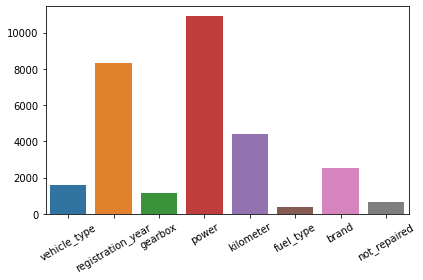

In [57]:
fi = pd.DataFrame({'Feature':x_train[0].columns,'Value':lg_1.feature_importances_})
display(fi.sort_values('Value',ascending=False).reset_index(drop=True).head())

fi = pd.Series(lg_1.feature_importances_, index=x_train[0].columns)
sns.barplot(x=x_train[0].columns, y=lg_1.feature_importances_)
plt.xticks(rotation=30)
plt.tight_layout()

**Основные выводы:**
 * в первую очередь стоит отметить, что все построенные модели продемонстрировали точность в разы лучше, нежели константаная модель, которая все машины оценивала средней ценой по всей выборке;
 * в нашем случае **стратегия удаления пропусков и выбросов показала гораздо лучшие результаты**, нежели стратегия заполнения: по ней метрика RMSE в среднем на 10% ниже (возможно, это объясняется изначально большой выборкой, которая позволила удалить все пропуски и выбросы без потери качества);
 * **наибольшую точность продемонстрировала модель градиентного бустинга LightGBM**, чуть хуже модель случайного леса и градиентного бустинга CatBoost;
 * скорость обучения всех моделей сильно зависит от настройки гиперпараметров, поиск которых сам по себе может занять очень  долгое время (Gridsearch требует много времени при большом объеме данных, Randomsearch позволяет значительно сократить время подбора). Ожидаемо минимальную скорость обучения имеет модель линейной регрессии, но у нее же и самое высокое значение RMSE среди обученных моделей. Больше всего времени занял подбор параметров для модели случайного леса. Но еще раз подчеркнем, что при других диапазонах это мог бы быть и CatBoost. Встроенной функции подбора гиперпараметров в библиотеке LightGBM не обнаружено.
 * наибольший вклад в стоимость автомобиля вносят признаки power (мощность дивгателя), registration_year (год регистрации автомобиля) и kilometer (его пробег).

**Вопрос ревьюеру**: можно ли как-то интерпретировать числовые значение того или иного признака? Сначала я думал, что это часть стоимости, но средняя цена по выборке менее 5000 евро, а здесь максимальный признак имеет значение почти 11 000.